In [1]:
import pandas as pd
import numpy as npC
import os

headers = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume(BTC)', 'Volume($)', 'WeightedPrice']
data = pd.DataFrame(columns=headers)

for filename in os.listdir('../datasets/bitcoin-5')[:10]:
    data = pd.concat([data, pd.read_csv(f'../datasets/bitcoin-5/{filename}', index_col=False)])
    print(filename)
    
data['Change'] = data['Open'] - data['Close']
data['PerChange'] = (data['Open'] - data['Close'])/data['WeightedPrice']

2020-06-01.csv
2020-06-02.csv
2020-06-03.csv
2020-06-04.csv
2020-06-05.csv
2020-06-06.csv
2020-06-07.csv
2020-06-08.csv
2020-06-09.csv
2020-06-10.csv


In [3]:
from finta import TA

smad = pd.DataFrame()

periods = [10,50,100,200]

for period in periods:
    smad[period] = getattr(TA, 'SMA')(data, period=period)

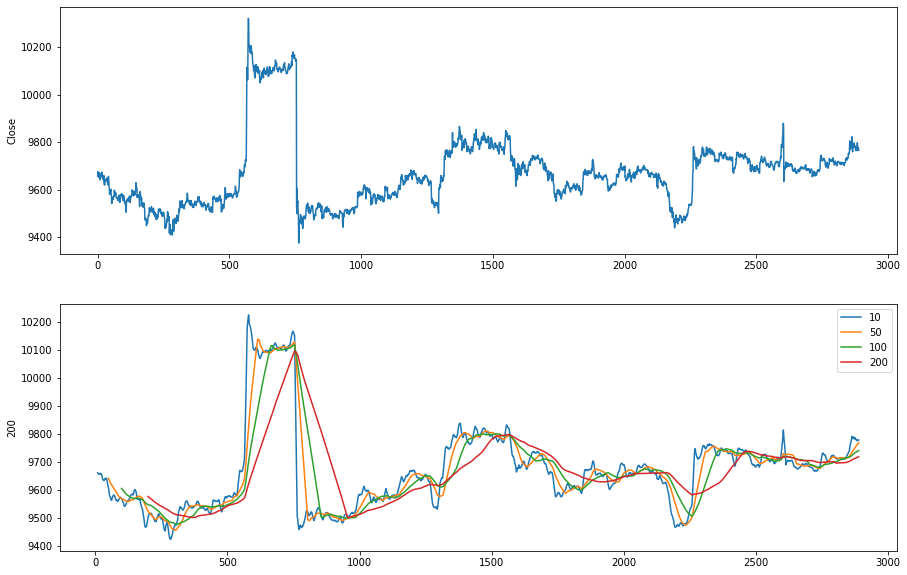

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, figsize=(15,10))
sns.lineplot(x=range(len(data)), y='Close', data=data, ax=axs[0])

for i, period in enumerate(periods):
    sns.lineplot(x=range(len(smad)), y=period, label=str(period), data=smad, ax=axs[1])

axs[1].legend()


In [51]:
smad['Change'] = data['Close'].diff(periods=12)

In [67]:
Xy = smad.dropna()
X, y = Xy.drop(['Change'], axis=1), Xy['Change']

In [83]:
y[y > 0] = 1
y[y < 0] = 0

print("Positives: ", len(y[y == 1]))
print("Negetives: ", len(y[y == 0]))

Positives:  1366
Negetives:  1325


In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

X_scaled = StandardScaler().fit_transform(X)
X_tsne = TSNE(n_components=2).fit_transform(X_scaled)

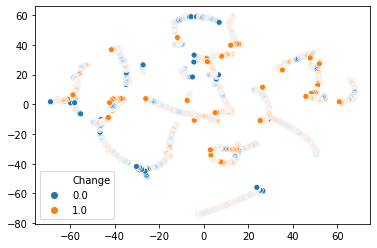

In [84]:
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, alpha=1)

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [109]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

d_clf = DecisionTreeClassifier(random_state=0)
d_clf.fit(X_scaled, y)
d_clf.score(X_scaled, y)

1.0

In [110]:
d_clf = DecisionTreeClassifier(random_state=0)
d_clf.fit(X_train, y_train)
print("train score: ", d_clf.score(X_train, y_train))
print("test score: ", d_clf.score(X_test, y_test))

train score:  1.0
test score:  0.7717996289424861


In [111]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
print("train score: ", rf_clf.score(X_train, y_train))
print("test score: ", rf_clf.score(X_test, y_test))

train score:  1.0
test score:  0.8144712430426716


In [173]:
for name, score in zip(X.columns, rf_clf.feature_importances_):
    print(name, score)

10 0.20928359592553303
50 0.253788722730901
100 0.26631901608713626
200 0.2706086652564296


In [113]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
print("train score: ", lr_clf.score(X_train, y_train))
print("test score: ", lr_clf.score(X_test, y_test))

train score:  0.637546468401487
test score:  0.660482374768089


# Adding MACD

In [162]:
total_X = smad.copy()
macd = TA.MACD(data)
total_X['MACD'] = macd['MACD']
total_X['SIGNAL'] = macd['SIGNAL']
total_X['DIFF'] = macd['MACD'] - macd['SIGNAL']

In [167]:
Xy2 = total_X.dropna()
X2, y2 = Xy2.drop(['Change'], axis=1), Xy2['Change']

y2[y2 > 0] = 1
y2[y2 < 0] = 0

Z:\anaconda\envs\btc\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [190]:
X_scaled2 = StandardScaler().fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2)

In [191]:
d_clf2 = DecisionTreeClassifier(random_state=0)
d_clf2.fit(X_train2, y_train2)
print("train score: ", d_clf2.score(X_train2, y_train2))
print("test score: ", d_clf2.score(X_test2, y_test2))

train score:  1.0
test score:  0.8237476808905381


In [192]:
rf_clf2 = RandomForestClassifier(random_state=0)
rf_clf2.fit(X_train2, y_train2)
print("train score: ", rf_clf2.score(X_train2, y_train2))
print("test score: ", rf_clf2.score(X_test2, y_test2))

train score:  1.0
test score:  0.8738404452690167


In [193]:
for name, score in zip(X2.columns, rf_clf2.feature_importances_):
    print(name, score)

10 0.07052513420414752
50 0.06957781508574659
100 0.07952412031571683
200 0.0732126007259383
MACD 0.1945081340459863
SIGNAL 0.12195699359631874
DIFF 0.39069520202614577


In [194]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(X_train2, y_train2)
print("train score: ", svm.score(X_train2, y_train2))
print("test score: ", svm.score(X_test2, y_test2))

train score:  0.8503717472118959
test score:  0.8682745825602969


# Adding Volume

In [210]:
total_X3 = total_X.copy()
total_X3['Volume'] = data['Volume(BTC)']

Xy3 = total_X3.dropna()
X3, y3 = Xy3.drop(['Change'], axis=1), Xy3['Change']

y3[y3 > 0] = 1
y3[y3 < 0] = 0

X_scaled3 = StandardScaler().fit_transform(X3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_scaled3, y3, test_size=0.2)

Z:\anaconda\envs\btc\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [211]:
d_clf3 = DecisionTreeClassifier(random_state=0)
d_clf3.fit(X_train3, y_train3)
print("train score: ", d_clf3.score(X_train3, y_train3))
print("test score: ", d_clf3.score(X_test3, y_test3))

train score:  1.0
test score:  0.8144712430426716


In [212]:
rf_clf3 = RandomForestClassifier(random_state=0)
rf_clf3.fit(X_train3, y_train3)
print("train score: ", rf_clf3.score(X_train3, y_train3))
print("test score: ", rf_clf3.score(X_test3, y_test3))

train score:  1.0
test score:  0.8608534322820037


In [213]:
for name, score in zip(X3.columns, rf_clf3.feature_importances_):
    print(name, score)

10 0.06043506075220681
50 0.061526969184247174
100 0.06715026051859418
200 0.06644733427364068
MACD 0.18263018226306144
SIGNAL 0.11723590134297773
DIFF 0.39116455270726014
Volume 0.05340973895801178
